In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from IPython.display import display

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [77]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

('2017-08-23')

C:\Users\etass\anaconda3\envs\class_31\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


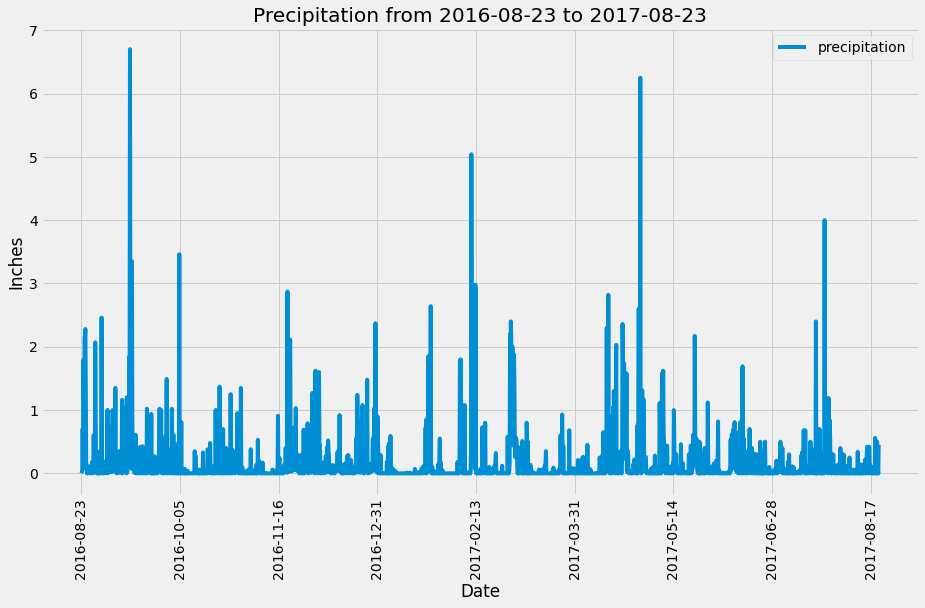

In [117]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Last date in dataset is 2017-8-23 so one year prior will be 2016-08-23
# Need dates in this range
# Latest Date found with this query or by examining data e.g. using DB Browser
display(session.query(Measurement.date).order_by(Measurement.date.desc()).first())

# Perform a query to retrieve the date and precipitation values

# Set the start and end dates required
# Set start date one day earlier to capture 2016-08-23
date_start = dt.datetime(2016,8,22)
date_end = dt.datetime(2017, 8, 23)

# Perform a query to retrieve the date and precipitation values
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > date_start).filter(Measurement.date <= date_end).all()

"""for result in results:
    (measurement_date, measurement_prcp) = result
    print(f"{measurement_date}  {measurement_prcp}")"""
    
# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(results)

# Drop any data points with NaN for precipitation as cannot be sure what has happened there
# Note that NaN (or NULL) is distinct from a precipitation of 0.0 which is recorded properly
date_prcp_df_clean = date_prcp_df.dropna()

# Set the index of the DataFrame to the date
date_prcp_df_clean.set_index("date", inplace=True)

# Sort the dataframe by date
date_prcp_df_clean_sort = date_prcp_df_clean.sort_index()

# Rename column prcp to precipitation for better display in plot
date_prcp_df_clean_sort.rename(columns = {"prcp" : "precipitation"}, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = date_prcp_df_clean_sort.plot(figsize=(14,8), rot=90, title="Precipitation from 2016-08-23 to 2017-08-23", xlabel="Date", ylabel="Inches");

# Produces warning -- from Google searching seems to be a bug in matplotlib currently
# Does not affect plot

In [116]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prcp_df_clean_sort.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [110]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()

# Print out result of query
print(f"There are {station_count} stations in the dataset.")

There are 9 stations in the dataset.


In [91]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Query counts how many times each station's name appears and sorts in descending order
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Display station_activity with row counts in descending order
display(station_activity)


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [90]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Station ID with most activity is USC00519281 with 2772 observations
# At location [0][0] in station_activity
most_active_station_temps = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_activity[0][0]).all()

# Display results 
# display(most_active_station_temps)

# Print out results nicely
print(f"Most active station is {most_active_station_temps[0][0]}")
print("----------------------------------------------------------")
print(f"Lowest temperature = {most_active_station_temps[0][1]}F")
print(f"Highest temperature = {most_active_station_temps[0][2]}F")
print(f"Average temperature = {most_active_station_temps[0][3]}F")

Most active station is USC00519281
----------------------------------------------------------
Lowest temperature = 54.0F
Highest temperature = 85.0F
Average temperature = 71.66378066378067F


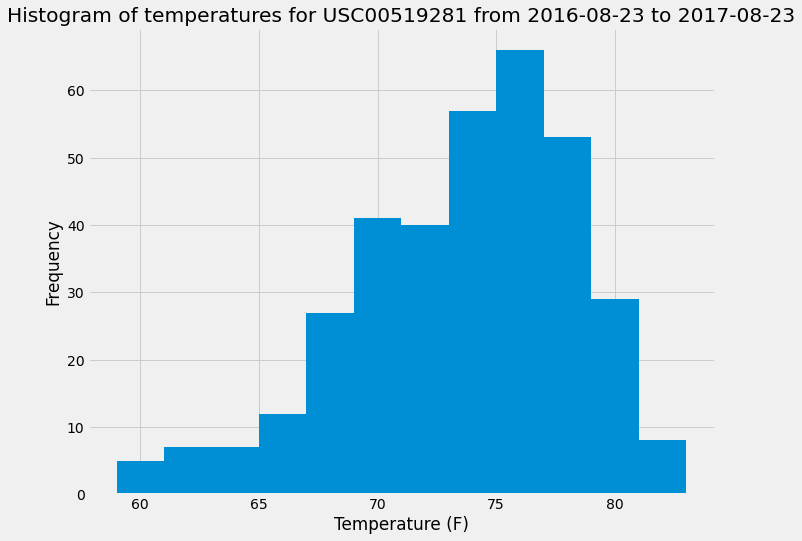

In [114]:
# Choose the station with the highest number of temperature observations

# Found this in previous section to be USC00519281 with 2772 observations
# At location [0][0] in station_activity

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Using dates from previous section 2016-08-23 to 2017-08-23
most_active_station_temps = session.query(Measurement.tobs).filter(Measurement.station == station_activity[0][0]).filter(Measurement.date > date_start).filter(Measurement.date <= date_end).all()

# Save temperatures into list from results using list comprehension
temperatures = [temp[0] for temp in most_active_station_temps[::]]

# Set up plot
fig, ax = plt.subplots(figsize=(10,8))

# Plot histogram with specified number of bins
plt.hist(temperatures, bins=12);

# Set x and y axis labels and plot title
ax.set_xlabel("Temperature (F)")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of temperatures for USC00519281 from 2016-08-23 to 2017-08-23");

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
